# Supplementary: Counts of differentially expressed genes per examined tissue

This notebook aggregates the results from the differential gene expression (**see** [figure1.ipynb](figure1.ipynb)), and more specifically the `limma::topTable()` output dataframes across all tissues in the GTEX cohort and generates summary statistics for the number of genes found to be statistically up or downregulated between male and female subjects.

 ---
 
 **Running this notebook**:
 
A few steps are needed before you can run this document on your own. The GitHub repository (https://github.com/TheJacksonLaboratory/sbas) of the project contains detailed instructions for setting up the environment in the **`dependencies/README.md`** document. Before starting with the analysis, make sure you have first completed the dependencies set up by following the instructions described there. If you have not done this already, you will need to close and restart this notebook before running it.

All paths defined in this Notebook are relative to the parent directory (repository). 

 ---


# Loading dependencies

In [1]:
library(dplyr)
library(tidyr)
library(reshape)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following objects are masked from ‘package:tidyr’:

    expand, smiths


The following object is masked from ‘package:dplyr’:

    rename


Warning message:
“package ‘ggplot2’ was built under R version 3.6.3”


## To get the last column fields of the GTF file to annotate the gene ids

The `limma::topTable()` dataframes encode the feature information (genes) as rownames of the dataframe. The values are Ensembl Gene IDs. To map the Gene ids to Gene symbold we will use a the fields in the last column of the relevant GTF file. 

Note: If you are using GENCODE to retrieve the GTF file, use the relevant field name for the gene ID:

| Source | Gene Identifier Name |
|---:|:---|
| GENCODE|`Geneid`|
| Ensembl|`gene_id`|


- Here are some quick links to retrieve the GTF file, either from Ensembl or GENCODE:

```bash
wget ftp://ftp.ensembl.org/pub/release-100/gtf/homo_sapiens/Homo_sapiens.GRCh38.100.chr_patch_hapl_scaff.gtf.gz -P ../data
wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_30/gencode.v30.chr_patch_hapl_scaff.annotation.gtf.gz -P ../data
```

- To parse the GTF file and retrieve the fields associated with the Gene IDs, Gene Symbols etc you could use the following bash snippet, depending on the source of your GTF (Ensembl, GENCODE) as these two files slightly differ.

```bash
# found here: https://www.biostars.org/p/140471/
cd sbas/data

zcat gencode.v30.annotation.gtf.gz | awk 'BEGIN{FS="\t"}{split($9,a,";"); if($3~"gene") print a[1]"\t"a[3]"\t"$1":"$4"-"$5"\t"a[2]"\t"$7}' |sed 's/gene_id "//' | sed 's/gene_id "//' | sed 's/gene_type "//'| sed 's/gene_name "//' | sed 's/"//g' | awk 'BEGIN{FS="\t"}{split($3,a,"[:-]"); print $1"\t"$2"\t"a[1]"\t"a[2]"\t"a[3]"\t"$4"\t"$5"\t"a[3]-a[2];}' | sed "1i\Geneid\tGeneSymbol\tChromosome\tStart\tEnd\tClass\tStrand\tLength" > gencode.v30.annotation.gtf.gz.txt

zcat Homo_sapiens.GRCh38.100.chr_patch_hapl_scaff.gtf.gz | awk 'BEGIN{FS="\t"}{split($9,a,";"); if($3~"gene") print a[1]"\t"a[3]"\t"$1":"$4"-"$5"\t"a[5]"\t"$7}' | sed 's/gene_id "//' | sed 's/gene_id "//' | sed 's/gene_biotype "//'| sed 's/gene_name "//' | sed 's/gene_biotype "//' | sed 's/"//g' | sed 's/ //g' | sed '1igene_id\tGeneSymbol\tChromosome\tClass\tStrand' > Homo_sapiens.GRCh38.100.chr_patch_hapl_scaff.gtf.gz.txt 
```

## Preview the GTF tables with the gene attributes

To make sure the snippets above have worked as expected, take a look in the tables with `head()`:

In [2]:
ensembl_path <- "Homo_sapiens.GRCh38.100.chr_patch_hapl_scaff.gtf.gz.txt"
gencode_path <- "gencode.v34.chr_patch_hapl_scaff.annotation.gtf.gz.txt"
gtf_ensembl <- read.table(paste0("../data/", ensembl_path), header = TRUE)
gtf_gencode <- read.table(paste0("../data/", gencode_path), header = TRUE)

head(gtf_ensembl,2)
head(gtf_gencode,2)

,gene_id,GeneSymbol,Chromosome,Class,Strand
,<fct>,<fct>,<fct>,<fct>,<fct>
1,ENSG00000223972,DDX11L1,1:11869-14409,transcribed_unprocessed_pseudogene,+
2,ENSG00000227232,WASH7P,1:14404-29570,unprocessed_pseudogene,-


,Geneid,GeneSymbol,Chromosome,Start,End,Class,Strand,Length
,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>
1,ENSG00000223972.5,DDX11L1,chr1,11869,14409,transcribed_unprocessed_pseudogene,+,2540
2,ENSG00000227232.5,WASH7P,chr1,14404,29570,unprocessed_pseudogene,-,15166


# Create a list of named dataframes with the Differential Gene Expression `limma::topTable()`s

We will iterate over the list of named dataframes to collect summary statistics. More specifically, retrieve the count of:
- upregulated
- downregulated
- non significant

genes for the contrast males-females per tissue.

In [3]:
dge_tables_filepaths <- list.files("../data/dge", pattern = "*DGE.csv", full.names = TRUE)
dge_tables_filenames <- list.files("../data/dge", pattern = "*DGE.csv", full.names = FALSE)

In [4]:
all_topTables <- lapply(dge_tables_filepaths,read.csv)
names(all_topTables) <- gsub("_DGE.csv","", dge_tables_filenames, fixed = TRUE)

The list named `all_topTables` is the object that holds all the topTable dataframes from each tissue comparison:

In [5]:
length(all_topTables)

[1] 46

In [6]:
summary(all_topTables)

                                     Length Class      Mode
Adipose-Subcutaneous                 6      data.frame list
Adipose-Visceral(Omentum)            6      data.frame list
AdrenalGland                         6      data.frame list
Artery-Aorta                         6      data.frame list
Artery-Coronary                      6      data.frame list
Artery-Tibial                        6      data.frame list
Bladder                              6      data.frame list
Brain-Amygdala                       6      data.frame list
Brain-Anteriorcingulatecortex(BA24)  6      data.frame list
Brain-Caudate(basalganglia)          6      data.frame list
Brain-CerebellarHemisphere           6      data.frame list
Brain-Cerebellum                     6      data.frame list
Brain-Cortex                         6      data.frame list
Brain-FrontalCortex(BA9)             6      data.frame list
Brain-Hippocampus                    6      data.frame list
Brain-Hypothalamus                   6  

# Trim gene versions from gene names to match Gene Identifiers from GTF (GENCODE, Ensembl)
Remove characters after `.` in the Gene Identifier column, since as long as the gene version information is present we will not be able to perform a join, to annotate the toptable dataframes with the GTF gene attrubutes.

In [7]:
#GTF_SOURCE <- "ensembl"      # c("gencode", "ensembl")
#GENE_ID    <- "gene_id"      # c("Geneid" , "gene_id")

GTF_SOURCE <- "gencode"      # c("gencode", "ensembl")
GENE_ID    <- "Geneid"      # c("Geneid" , "gene_id")

if (GTF_SOURCE == "gencode") { GTF <- gtf_gencode}
if (GTF_SOURCE == "ensembl") { GTF <- gtf_ensembl}

GTF[[GENE_ID]]       <- gsub("\\..*","", GTF[[GENE_ID]])

# Example with one topTable before iterating over all tissues

In [8]:
# Example topTable and name
topTable <- all_topTables[[1]]
name     <- names( all_topTables)[1]
topTable[[GENE_ID]]  <- gsub("\\..*","", rownames(topTable))
name
head(topTable,2)
head(GTF, 2)

[1] "Adipose-Subcutaneous"

,logFC,AveExpr,t,P.Value,adj.P.Val,B,Geneid
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000129824.15,-9.668735,4.643844,-145.5404,0,0,1136.058,ENSG00000129824
ENSG00000229807.10,9.907847,1.246117,131.3680,0,0,1079.040,ENSG00000229807


,Geneid,GeneSymbol,Chromosome,Start,End,Class,Strand,Length
,<chr>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>
1,ENSG00000223972,DDX11L1,chr1,11869,14409,transcribed_unprocessed_pseudogene,+,2540
2,ENSG00000227232,WASH7P,chr1,14404,29570,unprocessed_pseudogene,-,15166


## Defining the thresholds for the double criterion filtering:

Criteria:
- Adjusted p-value < `p_value_cuttoff`
- Absolut FoldChange > `absFold_change_threshold`

----

***NOTE***

Defining higher in males or females based on the limma design matrix
As we have used 1 for encoding the females and 2 for the males, our *reference level* for the contrast in the expression between males and females is 1, the females.


From the `limma` documentation:
>The level which is chosen for the *reference level* is the level which is contrasted against. By default, this is simply the first level alphabetically. We can specify that we want group 2 to be the reference level by either using the relevel function [..]

By convention, we could say that genes with positive log fold change, are higher in males, whereas the opposite holds true for the ones that are observed to have negative log folde change. 

---

In [9]:
adj.P.Val_threshold  <- 0.5
absFoldChange_cutoff <- 1.5

Replacing potential `NA` values in the `P.Value`, `adj.P.Val` to keep the columns numeric and avoid coersion.

In [10]:
# replacing NA p-values with p-value = 1
topTable$P.Value[is.na(topTable$P.Value)]     <- 1; 
topTable$adj.P.Val[is.na(topTable$adj.P.Val)] <- 1;

In [11]:
# Add helper variable dummy `FoldChange` variable. Use 2 as base of log, because this is the default from limma
# The following statement calculates a dummy fold change (how many times higher or lower)
# The minus symbol is a convention symbol only! to express eg. a fold change of 0.25 as -4, 4 times lower
topTable$FoldChange_dummy    <-   ifelse(topTable$logFC > 0, 2 ^ topTable$logFC, -1 / (2 ^ topTable$logFC))                    

# Add helper variable `abs_logFC`.
topTable$abs_logFC <- abs(topTable$logFC)

# Add helper variable `abundance` for up, down, non_signif
topTable$abundance                                                  <- "non_signif"
topTable$abundance[(topTable$logFC >   log2(absFoldChange_cutoff)) & (topTable$adj.P.Val <= adj.P.Val_threshold )]   <- "higher"
topTable$abundance[(topTable$logFC <  -log2(absFoldChange_cutoff)) & (topTable$adj.P.Val <= adj.P.Val_threshold )]   <- "lower"

In [12]:
head(topTable)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,Geneid,FoldChange_dummy,abs_logFC,abundance
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
ENSG00000129824.15,-9.668735,4.6438444,-145.54037,0,0,1136.0576,ENSG00000129824,-813.9156,9.668735,lower
ENSG00000229807.10,9.907847,1.2461171,131.36798,0,0,1079.0402,ENSG00000229807,960.6365,9.907847,higher
ENSG00000067048.16,-9.698380,3.7021122,-108.38685,0,0,952.4945,ENSG00000067048,-830.8129,9.698380,lower
ENSG00000176728.7,-8.082798,-0.9202562,-105.59458,0,0,922.2647,ENSG00000176728,-271.1219,8.082798,lower
ENSG00000012817.15,-9.608969,3.4369019,-101.87186,0,0,914.3474,ENSG00000012817,-780.8863,9.608969,lower
ENSG00000198692.9,-9.013909,1.3461188,-90.30504,0,0,835.7359,ENSG00000198692,-516.9601,9.013909,lower


# Define a vector with the columns to keep in the annotated from GTF `topTable` object

In [13]:
toKeep <- c("Geneid","logFC","FoldChange_dummy", "adj.P.Val", "abundance")

In [14]:
head(topTable[ , colnames(topTable) %in% toKeep ],2)

,logFC,adj.P.Val,Geneid,FoldChange_dummy,abundance
,<dbl>,<dbl>,<chr>,<dbl>,<chr>
ENSG00000129824.15,-9.668735,0,ENSG00000129824,-813.9156,lower
ENSG00000229807.10,9.907847,0,ENSG00000229807,960.6365,higher


In [15]:
name
dim(topTable)
dim(topTable [topTable$abundance != "non_signif",  ])
dim(topTable [ (topTable$abundance != "non_signif" )  & (topTable$adj.P.Val <= adj.P.Val_threshold ) ,  ])

[1] "Adipose-Subcutaneous"

[1] 15895    10

[1] 275  10

[1] 275  10

In [16]:
expression_abundance <- t(table(topTable$abundance))
expression_abundance

      
       higher lower non_signif
  [1,]     80   195      15620

In [17]:
expression_abundance <- t(table(topTable$abundance))
signif <- as.data.frame.matrix(expression_abundance)

In [18]:
signif

higher,lower,non_signif
<int>,<int>,<int>
80,195,15620


To avoid errors in the cases that we might have none lower or none higher, and the matrix might be missing columns we will create a template data.frame and also add the column that might be missing if lower or higher genes is equal to 0.

In [19]:
signif_template <- structure(list(higher = integer(0), 
                                   lower = integer(0), 
                                   non_signif = integer(0)), 
                              row.names = integer(0), class = "data.frame")
signif_template

higher,lower,non_signif
<int>,<int>,<int>


In the for-loop we will check if both columns `lower`, `higher` are present, if not add the column and zero count to create the expected sshape of the dataframe:

```R
signif <- as.data.frame.matrix(expression_abundance)
if(! ("higher" %in% colnames(signif))) { 
    
    signif$higher <- 0
}
if(! ("lower" %in% colnames(signif))) { 

    signif$lower <- 0
}
```

Now we can add some more summary statistics eg percentage of genes lower, higher or non-significantly different, 

In [20]:
signif$tissue <- name
signif$sum    <- signif$non_signif + signif$higher + signif$lower
toKeepInOrder <- c("tissue", "non_signif", "lower", "higher", "% lower", "% higher", "% non-signif")
signif$`% higher`     <-  round(signif$higher / signif$sum  * 100, 2)
signif$`% lower`      <-  round(signif$lower / signif$sum  * 100, 2)
signif$`% non-signif` <-  round(signif$non_signif / signif$sum  * 100, 2)
signif <- signif[, toKeepInOrder]
signif

tissue,non_signif,lower,higher,% lower,% higher,% non-signif
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
Adipose-Subcutaneous,15620,195,80,1.23,0.5,98.27


# Summary table of differentially expressed genes between male and female acrosss tissues

Above we demonstrate for one example limma `topTable`. Let's now iterate over all tissue and create an aggregated table of counts of differentially expressed or non-significantly altered between the two sexes.

In [21]:
summary_signif <-structure(list(tissue = character(0), 
                            non_signif = integer(0), 
                            lower = integer(0),
                            higher = integer(0),
                            `% lower` = numeric(0), 
                            `% higher` = numeric(0), 
                            `% non-signif` = numeric(0)), 
                       row.names = integer(0), 
                       class = "data.frame")

signif_template <- structure(list(higher = integer(0), 
                                   lower = integer(0), 
                                   non_signif = integer(0)), 
                              row.names = integer(0), class = "data.frame")

signif_per_tissue <- structure(list(logFC = numeric(0), AveExpr = numeric(0), t = numeric(0), 
                        P.Value = numeric(0), adj.P.Val = numeric(0), B = numeric(0), 
                        initial_gene_id = character(0), gene_id = character(0), abs_logFC = numeric(0), 
                        FoldChange_dummy = numeric(0), abundance = character(0), 
                        GeneSymbol = character(0), Chromosome = character(0), Class = character(0), 
                        Strand = character(0), tissue = character(0)), row.names = integer(0), class = "data.frame")


for (i in seq_along(all_topTables)){
    topTable <- all_topTables[[i]]
    name     <- names(all_topTables)[i] 
    initial_gene_id <- paste0("initial_", GENE_ID)
    topTable[[initial_gene_id]] <- rownames(topTable)
    topTable[[GENE_ID]]  <- gsub("\\..*","", rownames(topTable))
    # replacing NA p-values with p-value = 1
    topTable$P.Value[is.na(topTable$P.Value)]     <- 1; 
    topTable$adj.P.Val[is.na(topTable$adj.P.Val)] <- 1;
    topTable$abs_logFC <- abs(topTable$logFC)
    # Add helper variable dummy `FoldChange` variable. Use 2 as base of log, because this is the default from limma
    # The following statement calculates a dummy fold change (how many times higher or lower)
    # The minus symbol is a convention symbol only! to express eg. a fold change of 0.25 as -4, 4 times lower
    topTable$FoldChange_dummy    <-   ifelse(topTable$logFC > 0, 2 ^ topTable$logFC, -1 / (2 ^ topTable$logFC))                    

    # Add helper variable `abs_logFC`.
    topTable$abs_logFC <- abs(topTable$logFC)

    # Add helper variable `abundance` for up, down, non_signif
    topTable$abundance                                                  <- "non_signif"
    topTable$abundance[(topTable$logFC >   log2(absFoldChange_cutoff)) & (topTable$adj.P.Val <= adj.P.Val_threshold )]   <- "higher"
    topTable$abundance[(topTable$logFC <  -log2(absFoldChange_cutoff)) & (topTable$adj.P.Val <= adj.P.Val_threshold )]   <- "lower"
    before_gtf_merge <- dim(topTable)[1]
    topTable <- dplyr::left_join(topTable, GTF, by = GENE_ID)
    topTable_signif <- topTable[ topTable$abundance != "non_signif", ]
    topTable_signif$tissue <- name
    signif_per_tissue <- rbind(signif_per_tissue, topTable_signif )
    data.table::fwrite(file = paste0("../data/signif_", snakecase::to_snake_case(name), ".csv"), topTable_signif)
    after_gtf_merge <- dim(topTable)[1]
    message( name, ", N features before GTF merge: ",before_gtf_merge, ", after: ", after_gtf_merge)
    expression_abundance <- t(table(topTable$abundance))
    signif <- as.data.frame.matrix(expression_abundance)
    if(! ("higher" %in% colnames(signif))) {
        signif$higher <- 0
    }
    if(! ("lower" %in% colnames(signif))) {
        signif$lower <- 0
    }
    signif$tissue <- name
    signif$sum    <-   signif$non_signif + signif$higher + signif$lower
    toKeepInOrder <- c("tissue", "non_signif", "lower", "higher", "% lower", "% higher", "% non-signif")
    signif$`% higher`     <-  round(signif$higher / signif$sum  * 100, 2)
    signif$`% lower`      <-  round(signif$lower / signif$sum  * 100, 2)
    signif$`% non-signif` <-  round(signif$non_signif / signif$sum  * 100, 2)
    signif <- signif[, toKeepInOrder]
    summary_signif <- rbind(summary_signif, signif)   
}

summary_signif <- summary_signif[order(summary_signif$`% non-signif`), ]
head(summary_signif , 2)
head(signif_per_tissue, 2)

Adipose-Subcutaneous, N features before GTF merge: 15895, after: 15913

Adipose-Visceral(Omentum), N features before GTF merge: 15895, after: 15913

AdrenalGland, N features before GTF merge: 15895, after: 15913

Artery-Aorta, N features before GTF merge: 15895, after: 15913

Artery-Coronary, N features before GTF merge: 15895, after: 15913

Artery-Tibial, N features before GTF merge: 15895, after: 15913

Bladder, N features before GTF merge: 15895, after: 15913

Brain-Amygdala, N features before GTF merge: 15895, after: 15913

Brain-Anteriorcingulatecortex(BA24), N features before GTF merge: 15895, after: 15913

Brain-Caudate(basalganglia), N features before GTF merge: 15895, after: 15913

Brain-CerebellarHemisphere, N features before GTF merge: 15895, after: 15913

Brain-Cerebellum, N features before GTF merge: 15895, after: 15913

Brain-Cortex, N features before GTF merge: 15895, after: 15913

Brain-FrontalCortex(BA9), N features before GTF merge: 15895, after: 15913

Brain-Hippocam

,tissue,non_signif,lower,higher,% lower,% higher,% non-signif
,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
21,Breast-MammaryTissue,14096,686,1131,4.31,7.11,88.58
35,MinorSalivaryGland,15631,60,222,0.38,1.40,98.23


,logFC,AveExpr,t,P.Value,adj.P.Val,B,initial_Geneid,Geneid,abs_logFC,FoldChange_dummy,abundance,GeneSymbol,Chromosome,Start,End,Class,Strand,Length,tissue
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>,<chr>
1,-9.668735,4.643844,-145.5404,0,0,1136.058,ENSG00000129824.15,ENSG00000129824,9.668735,-813.9156,lower,RPS4Y1,chrY,2841602,2932000,protein_coding,+,90398,Adipose-Subcutaneous
2,9.907847,1.246117,131.3680,0,0,1079.040,ENSG00000229807.10,ENSG00000229807,9.907847,960.6365,higher,XIST,chrX,73820649,73852723,lncRNA,-,32074,Adipose-Subcutaneous


# Defining higher in males or females based on the limma design matrix
As we have used 1 for encoding the males and 2 for the females, our *reference level* for the contrast in the expression between males and females is 1, the males.


From the `limma` documentation:
>The level which is chosen for the *reference level* is the level which is contrasted against. By default, this is simply the first level alphabetically. We can specify that we want group 2 to be the reference level by either using the relevel function [..]

By convention, we could say that genes with positive log fold change, are higher in females, whereas the opposite holds true for the ones that are observed to have negative log folde change. 

In [22]:
summary_signif$`higher in males`   <- summary_signif$lower
summary_signif$`higher in females` <- summary_signif$higher
head(summary_signif[summary_signif$tissue == "Adipose-Subcutaneous", ])

,tissue,non_signif,lower,higher,% lower,% higher,% non-signif,higher in males,higher in females
,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,Adipose-Subcutaneous,15638,195,80,1.23,0.5,98.27,195,80


# Preparing the summary table for plotting

We will need to aggregate the number of genes in one column in order to be able to plot, and also convert the `Tissue` column to a factor. We will use the `reshape` R package to *melt* the dataframe from a wide to a long version, as described above:

In [23]:
toPlot <- summary_signif[, c( "tissue", "higher in males", "higher in females")]
toPlot <- reshape::melt(toPlot, id=c("tissue"))
toPlot$tissue <- as.factor(toPlot$tissue)
colnames(toPlot) <- c("Tissue", "Sex Bias", "Number of Genes")
head(toPlot[toPlot$Tissue == "Adipose-Subcutaneous", ])

,Tissue,Sex Bias,Number of Genes
,<fct>,<fct>,<dbl>
3,Adipose-Subcutaneous,higher in males,195
49,Adipose-Subcutaneous,higher in females,80


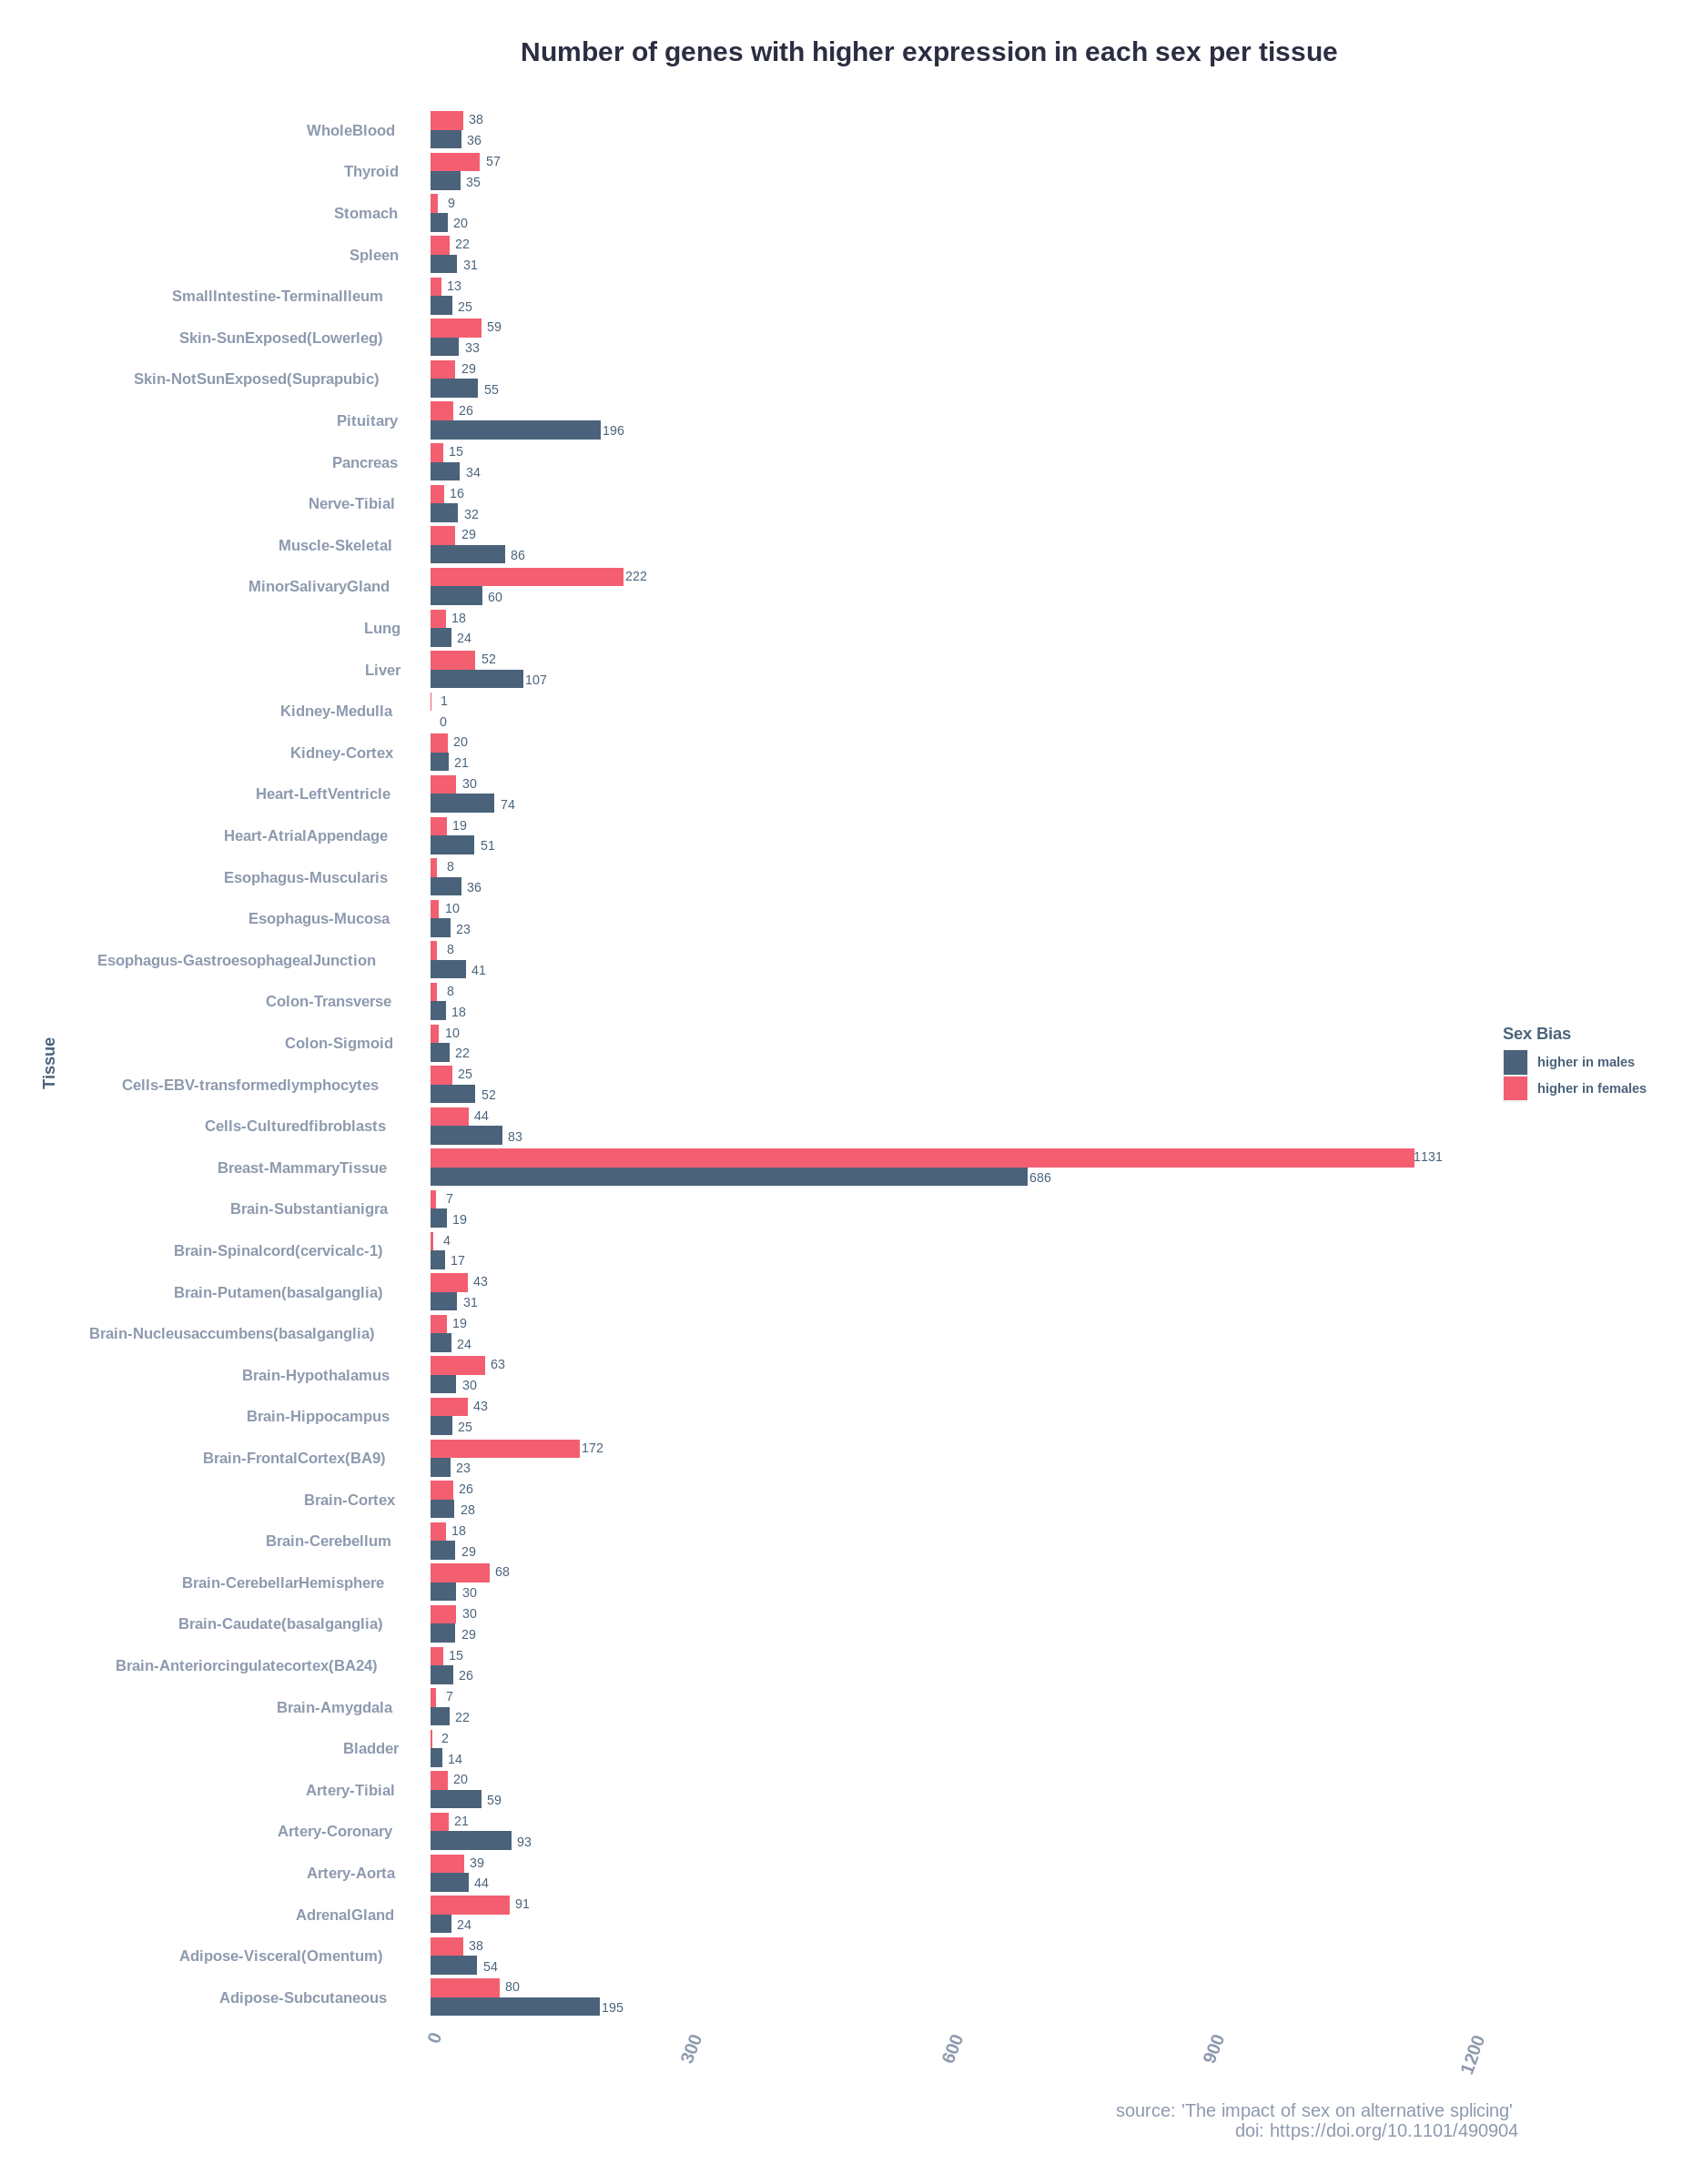

In [24]:
options(repr.plot.width=15.5, repr.plot.height=20)

ggplot(toPlot, aes(x = Tissue, y = `Number of Genes`, fill = `Sex Bias`)) + 
  geom_bar(stat="identity", position = "dodge") + 
  scale_fill_manual (values = c( "higher in males" = "#4A637B" , "higher in females" = "#f35f71")) + 
  
  theme(text              = element_text(color = "#4A637B", face = "bold", family = 'Helvetica')
        ,plot.caption     = element_text(size =  12, color = "#8d99ae", face = "plain", hjust= 1.05) 
        ,plot.title       = element_text(size =  18, color = "#2b2d42", face = "bold", hjust= 0.5)
        ,axis.text.y      = element_text(angle =  0, size = 10, color = "#8d99ae", face = "bold", hjust=1.1)
        ,axis.text.x      = element_text(angle = 70, size = 12, color = "#8d99ae", face = "bold", hjust=1.1)
        ,axis.title.x     = element_blank()
        ,axis.ticks.x     = element_blank()
        ,axis.ticks.y     = element_blank()
        ,plot.margin      = unit(c(1,1,1,1),"cm")
        ,panel.background = element_blank()
        ,legend.position  = "right") +
  

  geom_text(aes(y = `Number of Genes` + 15, 
                label = `Number of Genes`),
                size = 3,
                color     = "#4A637B",
                position  =  position_dodge(width = 1),
                family    = 'Helvetica') +
  
  labs(title   = "Number of genes with higher expression in each sex per tissue\n",
       caption = "\nsource: 'The impact of sex on alternative splicing'\n doi: https://doi.org/10.1101/490904",
       y   = "\nNumber of Differentially Expressed Genes")  + coord_flip()



# Mutually exclusive sex biased genes (higher expression in one or the other sex only)


The dataframe `signif_per_tissue` contains all the information for the genes that were significantly higher in either of the two sexes. WLet's examine how many mutually exclusive genes were found across all examined tissues. Ensembl encodes as `Chromosome` the chromosomal position, so we will create the required variables to retrieve only the chromosome information for producing summary statistics.

In [25]:
dput(colnames(signif_per_tissue))

c("logFC", "AveExpr", "t", "P.Value", "adj.P.Val", "B", "initial_Geneid", 
"Geneid", "abs_logFC", "FoldChange_dummy", "abundance", "GeneSymbol", 
"Chromosome", "Start", "End", "Class", "Strand", "Length", "tissue"
)


In [26]:
signif_per_tissue$Chromosomal_Position <- signif_per_tissue$Chromosome
signif_per_tissue$Chromosome <- gsub("\\:.*","", signif_per_tissue$Chromosome)
signif_per_tissue$higher_in  <- 0
signif_per_tissue$higher_in[(signif_per_tissue$abundance == "lower" )] <- "males"
signif_per_tissue$higher_in[(signif_per_tissue$abundance == "higher" )] <- "females"
toKeepInOrder <- c( paste0("initial_", GENE_ID), "GeneSymbol", "logFC",  "adj.P.Val", "abundance", "higher_in",  "tissue", "Chromosome", 
GENE_ID, "abs_logFC", "FoldChange_dummy", 
"Class", "Strand","Chromosomal_Position", 
 "AveExpr", "t", "P.Value", "adj.P.Val", "B")
signif_per_tissue <- signif_per_tissue[, toKeepInOrder]
head(signif_per_tissue, 4)

,initial_Geneid,GeneSymbol,logFC,adj.P.Val,abundance,higher_in,tissue,Chromosome,Geneid,abs_logFC,FoldChange_dummy,Class,Strand,Chromosomal_Position,AveExpr,t,P.Value,adj.P.Val.1,B
,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000129824.15,RPS4Y1,-9.668735,0,lower,males,Adipose-Subcutaneous,chrY,ENSG00000129824,9.668735,-813.9156,protein_coding,+,chrY,4.6438444,-145.5404,0,0,1136.0576
2,ENSG00000229807.10,XIST,9.907847,0,higher,females,Adipose-Subcutaneous,chrX,ENSG00000229807,9.907847,960.6365,lncRNA,-,chrX,1.2461171,131.3680,0,0,1079.0402
3,ENSG00000067048.16,DDX3Y,-9.698380,0,lower,males,Adipose-Subcutaneous,chrY,ENSG00000067048,9.698380,-830.8129,protein_coding,+,chrY,3.7021122,-108.3868,0,0,952.4945
4,ENSG00000176728.7,TTTY14,-8.082798,0,lower,males,Adipose-Subcutaneous,chrY,ENSG00000176728,8.082798,-271.1219,lncRNA,-,chrY,-0.9202562,-105.5946,0,0,922.2647


# Examine mutually exclusive genes upregulated in each sex

In [27]:
female_biased <- unique(signif_per_tissue[[paste0("initial_", GENE_ID)]] [ signif_per_tissue$higher_in == "females" ] )
male_biased   <- unique(signif_per_tissue[[paste0("initial_", GENE_ID)]] [ signif_per_tissue$higher_in == "males"  ] )

length(male_biased)
length(female_biased)

[1] 1301

[1] 1816

In [28]:
## Present in both

length((intersect(male_biased, female_biased)))
length((intersect(female_biased, male_biased)))

intersect <- (intersect(male_biased, female_biased))


[1] 462

[1] 462

In [29]:
## Only in males
length(male_biased[! (male_biased %in% intersect)])

## Only females
length(female_biased[! (female_biased %in% intersect)])

[1] 839

[1] 1354

In [30]:
perc_only_male <-  length(male_biased[! (male_biased %in% intersect)]) / length(male_biased) * 100
perc_only_female <-  length(female_biased[! (female_biased %in% intersect)]) / length(female_biased) * 100

head( signif_per_tissue[ signif_per_tissue[[paste0("initial_", GENE_ID)]] %in% male_biased[! (male_biased %in% intersect)],  ] , 4 )


message(round(perc_only_male, 2), " % of differentially expressed genes higher in males only found to be significantly differentin males")
message(round(perc_only_female,2), " % of differentially expressed genes higher in females only found to be significantly different in females")

,initial_Geneid,GeneSymbol,logFC,adj.P.Val,abundance,higher_in,tissue,Chromosome,Geneid,abs_logFC,FoldChange_dummy,Class,Strand,Chromosomal_Position,AveExpr,t,P.Value,adj.P.Val.1,B
,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000129824.15,RPS4Y1,-9.668735,0,lower,males,Adipose-Subcutaneous,chrY,ENSG00000129824,9.668735,-813.9156,protein_coding,+,chrY,4.6438444,-145.5404,0,0,1136.0576
3,ENSG00000067048.16,DDX3Y,-9.698380,0,lower,males,Adipose-Subcutaneous,chrY,ENSG00000067048,9.698380,-830.8129,protein_coding,+,chrY,3.7021122,-108.3868,0,0,952.4945
4,ENSG00000176728.7,TTTY14,-8.082798,0,lower,males,Adipose-Subcutaneous,chrY,ENSG00000176728,8.082798,-271.1219,lncRNA,-,chrY,-0.9202562,-105.5946,0,0,922.2647
5,ENSG00000012817.15,KDM5D,-9.608969,0,lower,males,Adipose-Subcutaneous,chrY,ENSG00000012817,9.608969,-780.8863,protein_coding,-,chrY,3.4369019,-101.8719,0,0,914.3474


64.49 % of differentially expressed genes higher in males only found to be significantly differentin males

74.56 % of differentially expressed genes higher in females only found to be significantly different in females



## Significantly higher only in males

In [31]:
dim(signif_per_tissue[ signif_per_tissue[[paste0("initial_", GENE_ID)]] %in% male_biased[! (male_biased %in% intersect)],  ])

only_male_genes <- signif_per_tissue[ signif_per_tissue[[paste0("initial_", GENE_ID)]] %in% (male_biased[! (male_biased %in% intersect)]) ,  ]

head(only_male_genes[ order(only_male_genes[[paste0("initial_", GENE_ID)]] ), ], 5)

[1] 2005   19

,initial_Geneid,GeneSymbol,logFC,adj.P.Val,abundance,higher_in,tissue,Chromosome,Geneid,abs_logFC,FoldChange_dummy,Class,Strand,Chromosomal_Position,AveExpr,t,P.Value,adj.P.Val.1,B
,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1284,ENSG00000000938.12,FGR,-0.6591010,9.573016e-15,lower,males,Breast-MammaryTissue,chr1,ENSG00000000938,0.6591010,-1.579098,protein_coding,-,chr1,4.869955,-8.358498,7.600595e-16,9.573016e-15,23.99783
165,ENSG00000002586.18,CD99,-0.7554926,1.219094e-56,lower,males,AdrenalGland,chrX,ENSG00000002586,0.7554926,-1.688208,protein_coding,+,chrX,6.790643,-21.507695,1.227147e-59,1.219094e-56,124.94664
172,ENSG00000002586.18,CD99,-0.7554926,1.219094e-56,lower,males,AdrenalGland,chrY,ENSG00000002586,0.7554926,-1.688208,protein_coding,+,chrY,6.790643,-21.507695,1.227147e-59,1.219094e-56,124.94664
282,ENSG00000002586.18,CD99,-0.8396619,5.671851e-08,lower,males,Brain-Amygdala,chrX,ENSG00000002586,0.8396619,-1.789631,protein_coding,+,chrX,6.061931,-6.959005,9.277642e-11,5.671851e-08,13.31987
291,ENSG00000002586.18,CD99,-0.8396619,5.671851e-08,lower,males,Brain-Amygdala,chrY,ENSG00000002586,0.8396619,-1.789631,protein_coding,+,chrY,6.061931,-6.959005,9.277642e-11,5.671851e-08,13.31987


In [32]:
# See 8.1.1 enquo() and !! - Quote and unquote arguments in https://tidyeval.tidyverse.org/dplyr.html

only_male_genes %>% 
    count( !!GENE_ID, GeneSymbol, Class, sort = TRUE) %>%
    head(20)

Warning message:
“Factor `GeneSymbol` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message:
“Factor `Class` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message:
“Factor `GeneSymbol` contains implicit NA, consider using `forcats::fct_explicit_na`”


"""Geneid""",GeneSymbol,Class,n
<chr>,<fct>,<fct>,<int>
Geneid,NA,NA,47
Geneid,AC010889.1,lncRNA,45
Geneid,DDX3Y,protein_coding,45
Geneid,EIF1AY,protein_coding,45
Geneid,KDM5D,protein_coding,45
Geneid,NLGN4Y,protein_coding,45
Geneid,PRKY,protein_coding,45
Geneid,RPS4Y1,protein_coding,45
Geneid,TMSB4Y,protein_coding,45


## Significantly higher only in females

In [33]:
only_female_genes <- signif_per_tissue[ signif_per_tissue[[paste0("initial_", GENE_ID)]] %in% (female_biased[! (female_biased %in% intersect)]) ,  ]

head(only_female_genes[ order(only_female_genes[[paste0("initial_", GENE_ID)]] ), ], 10)

,initial_Geneid,GeneSymbol,logFC,adj.P.Val,abundance,higher_in,tissue,Chromosome,Geneid,abs_logFC,FoldChange_dummy,Class,Strand,Chromosomal_Position,AveExpr,t,P.Value,adj.P.Val.1,B
,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
834,ENSG00000003096.14,KLHL13,1.0575276,5.849918e-18,higher,females,Breast-MammaryTissue,chrX,ENSG00000003096,1.0575276,2.081362,protein_coding,-,chrX,3.071957,9.379033,3.047331e-19,5.849918e-18,31.967423
2161,ENSG00000005187.11,ACSM3,1.7420707,6.241747e-30,higher,females,Breast-MammaryTissue,chr16,ENSG00000005187,1.7420707,3.345150,protein_coding,+,chr16,1.753435,12.678403,8.442753e-32,6.241747e-30,60.890589
3294,ENSG00000005379.15,TSPOAP1,0.8048674,2.635769e-08,higher,females,Breast-MammaryTissue,chr17,ENSG00000005379,0.8048674,1.746985,protein_coding,-,chr17,4.816506,5.948486,5.364399e-09,2.635769e-08,8.472351
747,ENSG00000005513.9,SOX8,1.0248677,1.091262e-18,higher,females,Breast-MammaryTissue,chr16,ENSG00000005513,1.0248677,2.034773,protein_coding,+,chr16,1.961977,9.601016,5.135350e-20,1.091262e-18,33.928616
20,ENSG00000005889.15,ZFX,0.6387585,8.312326e-49,higher,females,AdrenalGland,chrX,ENSG00000005889,0.6387585,1.556989,protein_coding,+,chrX,4.692241,19.191837,9.936093e-52,8.312326e-49,106.759601
173,ENSG00000005889.15,ZFX,0.6694278,1.284379e-85,higher,females,Artery-Aorta,chrX,ENSG00000005889,0.6694278,1.590442,protein_coding,+,chrX,4.987225,25.563606,1.373667e-88,1.284379e-85,191.042078
169,ENSG00000005889.15,ZFX,0.6289844,2.162584e-59,higher,females,Artery-Coronary,chrX,ENSG00000005889,0.6289844,1.546476,protein_coding,+,chrX,5.138006,22.882636,2.176870e-62,2.162584e-59,131.375327
179,ENSG00000005889.15,ZFX,0.6581554,6.019839e-122,higher,females,Artery-Tibial,chrX,ENSG00000005889,0.6581554,1.578064,protein_coding,+,chrX,5.168209,29.859299,6.438331e-125,6.019839e-122,274.344358
1612,ENSG00000005889.15,ZFX,0.6368501,1.684832e-17,higher,females,Brain-Amygdala,chrX,ENSG00000005889,0.6368501,1.554931,protein_coding,+,chrX,3.944298,10.763468,1.695961e-20,1.684832e-17,35.535455


In [34]:
only_female_genes %>% 
    count( !!GENE_ID, GeneSymbol, Class, sort = TRUE) %>%
    head(20)

Warning message:
“Factor `GeneSymbol` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message:
“Factor `Class` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message:
“Factor `GeneSymbol` contains implicit NA, consider using `forcats::fct_explicit_na`”


"""Geneid""",GeneSymbol,Class,n
<chr>,<fct>,<fct>,<int>
Geneid,XIST,lncRNA,46
Geneid,KDM6A,protein_coding,33
Geneid,ZFX,protein_coding,33
Geneid,PUDP,protein_coding,21
Geneid,MAP7D2,protein_coding,16
Geneid,NLRP2,protein_coding,16
Geneid,NA,NA,16
Geneid,JPX,lncRNA,12
Geneid,GSTM1,protein_coding,11


# Examine number of differentially expressed genes per chromosome per sex

In [35]:
signif_per_tissue$Chromosome <- as.factor(signif_per_tissue$Chromosome)
signif_per_tissue$higher_in <- as.factor(signif_per_tissue$higher_in)

signif_per_tissue %>% 
    group_by(Chromosome,higher_in) %>%  
    count()  -> signif_per_chrom_per_sex

Warning message:
“Factor `Chromosome` contains implicit NA, consider using `forcats::fct_explicit_na`”
Warning message:
“Factor `Chromosome` contains implicit NA, consider using `forcats::fct_explicit_na`”


In [36]:
signif_per_chrom_per_sex

Chromosome,higher_in,n
<fct>,<fct>,<int>
chr1,females,355
chr1,males,165
chr10,females,79
chr10,males,74
chr11,females,142
chr11,males,88
chr12,females,138
chr12,males,115
chr13,females,28


## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

In [37]:
notebook_id   = "summary_per_tissue_diff_expressed"

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data/ && sha256sum **/*csv > ../metadata/", notebook_id, "_sha256sums.txt"), intern = TRUE)
system(paste0("cd ../data/ && sha256sum *csv >> ../metadata/", notebook_id, "_sha256sums.txt"), intern = TRUE)

message("Done!\n")

data.table::fread(paste0("../metadata/", notebook_id, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

Generating sha256 checksums of the artefacts in the `..data/` directory .. 



character(0)

character(0)

Done!




sha256sum,file
<chr>,<chr>
f7bf10e5a2f335fb5eb92eab7749392ad3a96a959bce96f6075962555bc7f072,dge/Adipose-Subcutaneous_DGE.csv
3769ae0c0a05f6884e510a227d8d517bbe74b6147b4d9c5dcd097a5cc71661c5,dge/Adipose-Visceral(Omentum)_DGE.csv
a68be6697a068235f45f956b90c45eeb7b83785b215e7d75f32a3c7fd651373e,dge/AdrenalGland_DGE.csv
fe04ff9e0c445ac67aaf2d12ee152ff164a9eb4d23b3cbf0a770c3d0e7841bbe,dge/Artery-Aorta_DGE.csv
83292d3a6bf7583598ec60940bc2f29ffc2139e8923b5731ae5d33bfeca3ead0,dge/Artery-Coronary_DGE.csv
588b0aee472c299a9d9aaed572177a8a816ace8ca3419152da7966505d5a7a52,dge/Artery-Tibial_DGE.csv
5b69dcb829a68c0fef9db8e9fd091afec4dd1c2bbf2eb3d220dc279582403f0e,dge/Bladder_DGE.csv
5e67e3716f94dcd032eec1468a86e95e22d923d718b28f04d7b4d863411ad6e5,dge/Brain-Amygdala_DGE.csv
79ef74c37d1c0ec3622898d9c67d441f085407a0fa9b2efb7696bf946c9a7efd,dge/Brain-Anteriorcingulatecortex(BA24)_DGE.csv


### 2. Libraries metadata

In [38]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", notebook_id, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", notebook_id ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..

Done!


Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..

Done!




 setting  value                       
 version  R version 3.6.2 (2019-12-12)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-05-10                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
dplyr,dplyr,0.8.4,0.8.4,/opt/conda/lib/R/library/dplyr,/opt/conda/lib/R/library/dplyr,TRUE,FALSE,2020-01-31,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
ggplot2,ggplot2,3.3.0,3.3.0,/opt/conda/lib/R/library/ggplot2,/opt/conda/lib/R/library/ggplot2,TRUE,FALSE,2020-03-05,CRAN (R 3.6.3),NA,/opt/conda/lib/R/library
reshape,reshape,0.8.8,0.8.8,/opt/conda/lib/R/library/reshape,/opt/conda/lib/R/library/reshape,TRUE,FALSE,2018-10-23,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
tidyr,tidyr,1.0.3,1.0.3,/opt/conda/lib/R/library/tidyr,/opt/conda/lib/R/library/tidyr,TRUE,FALSE,2020-05-07,CRAN (R 3.6.2),NA,/opt/conda/lib/R/library
